In [41]:
import pandas as pd
import os
import torch
import json
import numpy as np

In [42]:
%run ../Config.ipynb

In [43]:
config = Config()

#### Rmsd's 

In [44]:
#file_name_rmsd = 'rmsd'
file_name_rmsd = "rmsd_refined_set"

In [45]:
rmsd = pd.read_csv(f"{config.data}/{file_name_rmsd}.csv").sort_values(['pdb','poserank','RMSD']).drop_duplicates(['pdb','poserank'], keep = 'first')

sup = rmsd.groupby('pdb')[['poserank']].count().reset_index().rename(columns = {"poserank":"poserank_count"})
sup['unique_pdb_count'] = sup.groupby('poserank_count')['pdb'].transform('nunique')
sup.drop(columns = ['pdb']).drop_duplicates().sort_values('poserank_count')

,poserank_count,unique_pdb_count
107,1,75
95,2,83
156,3,60
7,4,50
33,5,60
67,6,61
212,7,70
1,8,91
10,9,402
0,10,2988


In [46]:
rmsd['pdb'].nunique()

3940

In [47]:
sup = rmsd.groupby('pdb')[['poserank']].count().reset_index().rename(columns = {"poserank":"poserank_count"})
sup['unique_pdb_count'] = sup.groupby('poserank_count')['pdb'].transform('nunique')
sup.drop(columns = ['pdb']).drop_duplicates().sort_values('poserank_count')

,poserank_count,unique_pdb_count
107,1,75
95,2,83
156,3,60
7,4,50
33,5,60
67,6,61
212,7,70
1,8,91
10,9,402
0,10,2988


In [48]:
import seaborn as sns

In [49]:
len(rmsd)

36003

<AxesSubplot:xlabel='poserank'>

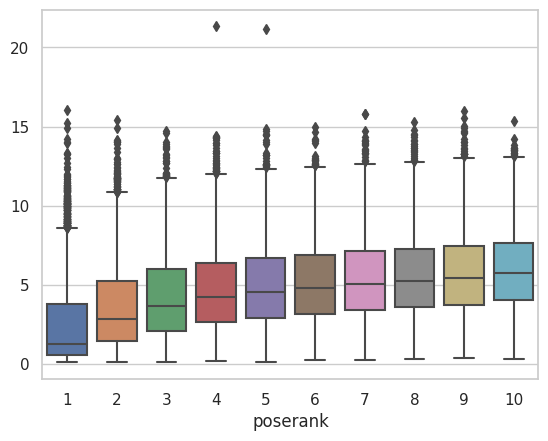

In [50]:
sns.boxplot(rmsd.pivot_table(index = 'pdb', columns = 'poserank', values = 'RMSD'))

#### Creating label 

In [51]:
label = rmsd.copy()

#### Score similarity 

In [52]:
score = pd.read_json(f"{config.data}/score.json").unstack().reset_index().rename(columns = {"level_0":"pdb", "level_1":"poserank", 0:'similarity'})

In [53]:
score.head()

,pdb,poserank,similarity
0,3oy8,1,8.641975
1,3oy8,2,4.938272
2,3oy8,3,7.407407
3,3oy8,4,3.703704
4,3oy8,5,6.172840


In [54]:
score['pdb'].nunique()

5316

#### Merge

In [55]:
label = pd.merge(score, label, left_on= ['pdb','poserank'], right_on = ['pdb','poserank'], how = 'outer').drop_duplicates()

#### Conditions

In [56]:
# Define the conditions and corresponding scores
conditions_rmsd = [ label['RMSD'] < 2
              ,(label['RMSD'] >= 2) & (label['RMSD'] < 3)
              , label['RMSD'] >= 3]

In [57]:
conditions_similarity = [ label['similarity'] >=80 
              ,(label['similarity'] >= 70) & (label['similarity'] < 80)
              #,(label['similarity'] >= 66) & (label['similarity'] < 70)
              , label['similarity'] < 70 ]

In [58]:
scores_rmsd       = [10, 7, 0]
scores_similarity = [10, 7, 0]

label['rmsd_weight'] = np.select(conditions_rmsd, scores_rmsd, default=np.nan)
label['similarity_weight'] = np.select(conditions_similarity, scores_similarity, default=np.nan)

#### Métrica 

$$
\frac{{\text{{score\_rmsd}} \times 0.5 + \text{{score\_match}} \times 0.5}}{{20}}
$$


In [59]:
label['weight'] = (label['rmsd_weight']*0.5 + label['similarity_weight']*0.5)/10
label['weight_similarity'] = (label['rmsd_weight']*0.3 + label['similarity_weight']*0.7)/10
label['weight_rmsd'] = (label['rmsd_weight']*0.7 + label['similarity_weight']*0.3)/10

In [60]:
label['weight'].value_counts()

0.00    24031
0.35     4690
0.50     3784
0.85     1364
1.00     1138
0.70      224
Name: weight, dtype: int64

In [61]:
label["label"] = label["weight"].apply(lambda x: 1 if x > 0.5 else 0)

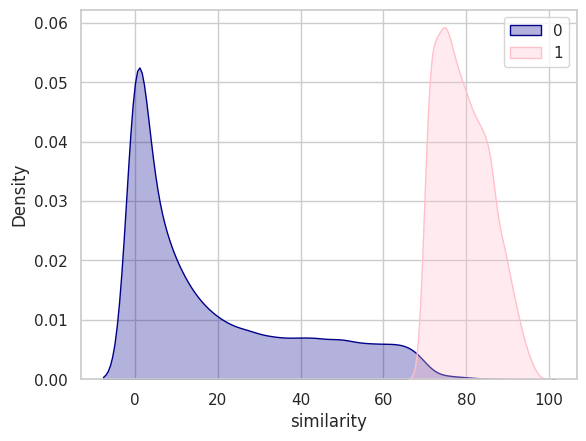

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for the plot
sns.set(style="whitegrid")

# Create a figure and axis
fig, ax = plt.subplots()

# Plot density plots for each class with increased transparency
sns.kdeplot(data=label[label['label'] == 0], x='similarity', fill=True, color='darkblue', alpha=0.3, ax=ax, label='0')
sns.kdeplot(data=label[label['label'] == 1], x='similarity', fill=True, color='pink', alpha=0.3, ax=ax, label='1')

# Show the legend
ax.legend()

# Display the plot
plt.show()


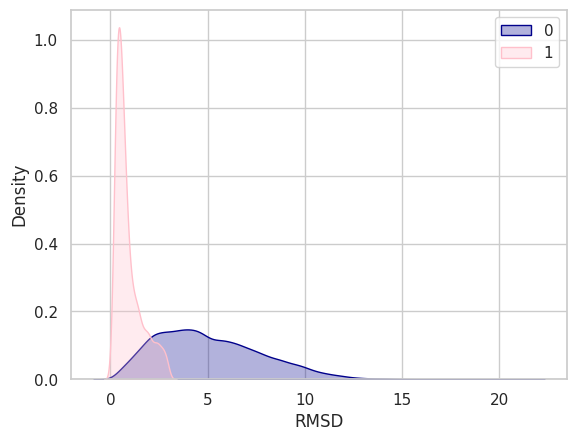

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for the plot
sns.set(style="whitegrid")

# Create a figure and axis
fig, ax = plt.subplots()

# Plot density plots for each class with increased transparency
sns.kdeplot(data=label[label['label'] == 0], x='RMSD', fill=True, color='darkblue', alpha=0.3, ax=ax, label='0')
sns.kdeplot(data=label[label['label'] == 1], x='RMSD', fill=True, color='pink', alpha=0.3, ax=ax, label='1')

# Show the legend
ax.legend()

# Display the plot
plt.show()


#### Stats

In [64]:
len(label['label'])

53160

In [65]:
label['pdb'].nunique()

5316

In [66]:
label['label'].value_counts(1)

0    0.948721
1    0.051279
Name: label, dtype: float64

#### Report 

In [67]:
#best_weight = label.sort_values(["pdb", "weight"], ascending = False).drop_duplicates("pdb", keep = "first")
#best_weight_similarity = label.sort_values(["pdb", "weight_similarity"], ascending = False).drop_duplicates("pdb", keep = "first")
#best_weight_rmsd = label.sort_values(["pdb", "weight_rmsd"], ascending = False).drop_duplicates("pdb", keep = "first")

In [68]:
#label.sort_values(["pdb", "weight"], ascending = False).head(30)

In [69]:
#merged_best_weight = pd.merge(best_weight, lepton, on = ['pdb'], how = "inner")
#merged_best_weight_similarity = pd.merge(best_weight_similarity, lepton, on = ['pdb'], how = "inner")
#merged_best_weight_rmsd = pd.merge(best_weight_rmsd, lepton, on = ['pdb'], how = "inner")

#### Functions 

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_count_distribution(data, x, hue):
    # Set the style for the plot
    sns.set(style="whitegrid")

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot a bar plot with hue for each class
    sns.countplot(data=data, x=x, hue=hue, palette='Set2')

    # Set the plot labels and title
    ax.set(xlabel='Class', ylabel='Count', title='Distribution of Classes with Score Hue')

    # Format x-axis labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

    # Display the plot
    plt.show()

In [209]:
def filter_and_print_label_distribution(dataset_list_final):
    filtered_data_list_num_nodes = [data for data in dataset_list_final if data.num_nodes > 0]
    filtered_data_list_descriptors = [data for data in filtered_data_list_num_nodes if data.x_s.shape[0] > 0 and data.x_t.shape[0] > 0]
    filtered_data_list_descriptors = [data for data in filtered_data_list_descriptors if not data.x_t[0, 2].isnan()] 
    filtered_data_list = filtered_data_list_descriptors.copy()
    
    label_distribution = dict(Counter([label.y.tolist() for label in filtered_data_list]))
    amount_of_graphs_used_to_train = len(filtered_data_list)
    
    print("Label Distribution:")
    for label, count in label_distribution.items():
        print(f"Label {label}: {count}")
    
    print(f"Amount of Graphs Used to Train: {amount_of_graphs_used_to_train}")
    
    return filtered_data_list

#### Last problem 

In [189]:
import pickle

In [190]:
def save_list_to_file(data_list, config, name):
    with open(f'{config.data}/{name}', 'wb') as file:
        pickle.dump(data_list, file)
        print(f'Saved {name} with success!')

def open_file(config, name):
    with open(f'../Datahub/Data/{name}', 'rb') as file:
        bipartite_data = pickle.load(file) 
    return bipartite_data

In [191]:
dataset = label.copy()

In [192]:
dataset = dataset[['pdb','poserank','similarity','RMSD','label']]

#### Coreset 

In [193]:
from torch_geometric.data import Data, DataLoader

In [194]:
class BipartiteData(Data):
    def __init__(self, edge_index=None, x_s=None, x_t=None, y=None, edge_attr=None, pdb = None, pose = None):
        super().__init__()
        self.edge_index = edge_index
        self.x_s = x_s
        self.x_t = x_t
        self.y = y
        self.edge_attr = edge_attr  # Add edge_attr attribute
        #self.num_nodes = len(set(edge_index[0].tolist())) +  len(set(edge_index[1].tolist()))
        self.num_nodes = (x_s.size(0) if x_s is not None else 0) + (x_t.size(0) if x_t is not None else 0)
        self.pdb = pdb
        self.pose = pose
    
    def __inc__(self, key, value, *args, **kwargs):
        if key == 'edge_index':
            return torch.tensor([[self.x_s.size(0)], [self.x_t.size(0)]])
        else:
            return super().__inc__(key, value, *args, **kwargs)

In [338]:
working = open_file(config, "bipartite_data_no_pose_rank_NOT_sorted_by_family_cut_4_coreset_1_RAND.pkl")

In [339]:
working = filter_and_print_label_distribution(working)

Label Distribution:
Label 0.0: 1802
Label 1.0: 146
Amount of Graphs Used to Train: 1948


In [340]:
order_dataset_that_works = []
for data in working:
    order_dataset_that_works.append(data.pdb)

#### refined set 

In [355]:
fail = open_file(config, "bipartite_data_no_pose_rank_cut_4_refined_set_encoded_RAND.pkl")

In [356]:
fail = filter_and_print_label_distribution(fail)

Label Distribution:
Label 0.0: 25442
Label 1.0: 2209
Amount of Graphs Used to Train: 27651


In [357]:
len(set([data.pdb for data in fail]) & set([data.pdb for data in working]) )

165

In [358]:
def pdb_index(item):
    try:
        return order_dataset_that_works.index(item.pdb)
    except ValueError:
        return float('inf')  # Return a very large value if PDb not found

In [359]:
len(order_dataset_that_works)

1948

In [360]:
list_pdb_coreset = list(set([data.pdb for data in working]))

In [361]:
len(list_pdb_coreset)

231

In [362]:
fail_with_coreset_pdb = [data for data in fail if data.pdb in     list_pdb_coreset]

In [363]:
len(fail_with_coreset_pdb)

1321

In [364]:
fail = [data for data in fail if data.pdb not in order_dataset_that_works]

In [365]:
len(fail)

26330

In [366]:
len(fail_with_coreset_pdb)

1321

In [367]:
fail = sorted(fail, key =  lambda item : item.pdb)
fail_with_coreset_pdb = sorted(fail_with_coreset_pdb, key =  lambda item : item.pdb)

In [368]:
fail = fail[:1948]
fail_with_coreset_pdb = fail_with_coreset_pdb[:1948]

In [369]:
len(fail_with_coreset_pdb)

1321

In [221]:
import random

In [222]:
random.shuffle(fail)

In [223]:
from collections import Counter

#### Comparing Proportion 

In [224]:
dict(Counter([data.y.tolist() for data in fail]))

{0.0: 1809, 1.0: 139}

In [225]:
dict(Counter([data.y.tolist() for data in working]))

{0.0: 1802, 1.0: 146}

#### Comparting dataframe

In [226]:
list_pdb_fail = [data.pdb for data in fail]
list_pdb_working = [data.pdb for data in working]

In [227]:
set(list_pdb_fail) &  set(list_pdb_working)

set()

In [228]:
dataset_fail = dataset[dataset['pdb'].isin(list_pdb_fail)]
dataset_working = dataset[dataset['pdb'].isin(list_pdb_working)]

In [229]:
dataset_fail['label'].value_counts()

0    2151
1     139
Name: label, dtype: int64

In [230]:
dataset_working['label'].value_counts()

0    2031
1     109
Name: label, dtype: int64

In [231]:
dataset_fail.head()


,pdb,poserank,similarity,RMSD,label
260,1g7q,1,53.254438,2.22,0
261,1g7q,2,8.875740,14.05,0
262,1g7q,3,23.668639,4.15,0
263,1g7q,4,11.834320,5.81,0
264,1g7q,5,72.781065,0.94,1


#### Classes postitivas 

In [232]:
table_fail = dataset_fail[~dataset_fail['pdb'].isin(list(dataset_fail[dataset_fail['label']== 1]['pdb']))]

In [233]:
table_fail['pdb'].nunique()

125

In [234]:
dataset_fail['pdb'].nunique()

229

In [235]:
table_working = dataset_working[~dataset_working['pdb'].isin(list(dataset_working[dataset_working['label']== 1]['pdb']))]

In [236]:
table_working['pdb'].nunique()

118

In [237]:
dataset_working['pdb'].nunique()

214

#### Tentando rodar modelo de novo para garantir 

In [238]:
dict(Counter([data.y.tolist() for data in fail]))

{0.0: 1809, 1.0: 139}

In [245]:
1809/139

13.014388489208633

In [239]:
dict(Counter([data.y.tolist() for data in working]))

{0.0: 1802, 1.0: 146}

In [247]:
1802/146

12.342465753424657

In [371]:
dict(Counter([data.y.tolist() for data in fail_with_coreset_pdb]))

{0.0: 1214, 1.0: 107}

In [372]:
1214/107

11.345794392523365

In [351]:
len(fail_with_coreset_pdb)

1321

In [352]:
1321*0.2

264.2

In [353]:
1321  - 264

1057

In [370]:
save_list_to_file(fail, config, f"DATAVALIDATION_1948_FAILED.pkl")
save_list_to_file(fail_with_coreset_pdb, config, f"DATAVALIDATION_1321_SHOULD_WORK.pkl")

Saved DATAVALIDATION_1948_FAILED.pkl with success!
Saved DATAVALIDATION_1321_SHOULD_WORK.pkl with success!


In [252]:
working[0:10]

[BipartiteData(edge_index=[2, 114], x_s=[114, 7], x_t=[114, 7], y=0.0, edge_attr=[114], num_nodes=228, pdb='3kwa', pose=1),
 BipartiteData(edge_index=[2, 39], x_s=[39, 7], x_t=[39, 7], y=0.0, edge_attr=[39], num_nodes=78, pdb='3udh', pose=8),
 BipartiteData(edge_index=[2, 89], x_s=[89, 7], x_t=[89, 7], y=0.0, edge_attr=[89], num_nodes=178, pdb='2qnq', pose=4),
 BipartiteData(edge_index=[2, 103], x_s=[103, 7], x_t=[103, 7], y=0.0, edge_attr=[103], num_nodes=206, pdb='3b65', pose=6),
 BipartiteData(edge_index=[2, 72], x_s=[72, 7], x_t=[72, 7], y=0.0, edge_attr=[72], num_nodes=144, pdb='2vw5', pose=2),
 BipartiteData(edge_index=[2, 52], x_s=[52, 7], x_t=[52, 7], y=0.0, edge_attr=[52], num_nodes=104, pdb='5c28', pose=8),
 BipartiteData(edge_index=[2, 42], x_s=[42, 7], x_t=[42, 7], y=0.0, edge_attr=[42], num_nodes=84, pdb='3fcq', pose=4),
 BipartiteData(edge_index=[2, 116], x_s=[116, 7], x_t=[116, 7], y=0.0, edge_attr=[116], num_nodes=232, pdb='1mq6', pose=6),
 BipartiteData(edge_index=[2, 

In [251]:
fail[0:10]

[BipartiteData(edge_index=[2, 138], x_s=[138, 11], x_t=[138, 11], y=0.0, edge_attr=[138], num_nodes=276, pdb='1dif', pose=7),
 BipartiteData(edge_index=[2, 60], x_s=[60, 11], x_t=[60, 11], y=0.0, edge_attr=[60], num_nodes=120, pdb='1c5q', pose=5),
 BipartiteData(edge_index=[2, 94], x_s=[94, 11], x_t=[94, 11], y=0.0, edge_attr=[94], num_nodes=188, pdb='1c1r', pose=9),
 BipartiteData(edge_index=[2, 100], x_s=[100, 11], x_t=[100, 11], y=0.0, edge_attr=[100], num_nodes=200, pdb='1d3d', pose=5),
 BipartiteData(edge_index=[2, 80], x_s=[80, 11], x_t=[80, 11], y=0.0, edge_attr=[80], num_nodes=160, pdb='1fao', pose=3),
 BipartiteData(edge_index=[2, 192], x_s=[192, 11], x_t=[192, 11], y=0.0, edge_attr=[192], num_nodes=384, pdb='1izh', pose=7),
 BipartiteData(edge_index=[2, 19], x_s=[19, 11], x_t=[19, 11], y=0.0, edge_attr=[19], num_nodes=38, pdb='187l', pose=3),
 BipartiteData(edge_index=[2, 23], x_s=[23, 11], x_t=[23, 11], y=0.0, edge_attr=[23], num_nodes=46, pdb='1d7i', pose=6),
 BipartiteData